In [ ]:
from plot import plot_data, merge_bom_epa, create_heatmap, plot_air_quality_and_sentiment, bom_health
import ipywidgets as widgets
from IPython.display import display, clear_output
from get_data import twitter, epa, bom, health
import pandas as pd
import requests

In [ ]:
city = None
disease = None

city_textbox = widgets.Text(
    value='',
    description='City:',
    disabled=False
)

disease_textbox = widgets.Text(
    value='COPD',
    description='Disease:',
    disabled=False
)

button = widgets.Button(description="Update Plot")

def on_button_clicked(b):
    global city, disease
    city = city_textbox.value
    disease = disease_textbox.value
    clear_output(wait=True)
    display(city_textbox, disease_textbox, button)
    plot_data(start=1, end=14, city=city, disease=disease, size=2000)

button.on_click(on_button_clicked)

display(city_textbox, disease_textbox, button)

In [12]:
from match_url import twitter, epa, bom, health
import pandas as pd
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import calendar

In [2]:
epa = epa()
epa_df = pd.DataFrame(epa)

twitter = twitter()
twitter_df = pd.DataFrame(twitter)

bom = bom()
bom_df = pd.DataFrame(bom)

health = health()
health_df = pd.DataFrame(health)

In [ ]:
print(health_df)

In [ ]:
print(bom_df)

In [ ]:
print(epa_df)

In [ ]:
print(twitter_df)

In [ ]:
disease = 'COPD'

In [3]:
    # health_df = health_df[health_df['Disease'] == disease]
    bom_df['local_date_time'] = pd.to_datetime(bom_df['local_date_time'], format='%Y%m%d%H%M%S')
    bom_df['date'] = bom_df['local_date_time'].dt.date

    # Calculate daily average temperature
    daily_avg_temp = bom_df.groupby('date')['apparent_temperature'].mean().reset_index()
    daily_avg_temp.columns = ['date', 'avg_temperature']
    
    # Determine the minimum length to merge on
    min_length = min(len(daily_avg_temp), len(health_df))
    
    # Truncate both dataframes to the minimum length
    daily_avg_temp = daily_avg_temp.iloc[:min_length]
    health_df = health_df.iloc[:min_length]

In [4]:
merged_df = merged_df = pd.merge(daily_avg_temp, health_df, left_index=True, right_index=True)
print(merged_df)

         date  avg_temperature      ASR                      Disease  \
0  2024-05-03        11.300000   22.900        Breast_Cancer_Females   
1  2024-05-04         8.587500   17.500  Respiratory_System_Diseases   
2  2024-05-05        11.768750   31.000      Ischaemic_Heart_Disease   
3  2024-05-06        11.450000   19.367                  Lung_Cancer   
4  2024-05-07        10.304167    8.148     Cerebrovascular_Diseases   
5  2024-05-08        12.489583  107.356                       Cancer   
6  2024-05-09        12.137500   19.779        Breast_Cancer_Females   
7  2024-05-10        14.541667   11.752                         COPD   

        LGA    NUM     PHN     Period     SR  
0  Campaspe   23.0  Murray  2010-2014  140.0  
1  Campaspe   39.0  Murray  2010-2014  119.0  
2  Campaspe   67.0  Murray  2010-2014  129.0  
3  Campaspe   43.0  Murray  2011-2015   92.0  
4  Campaspe   18.0  Murray  2011-2015  101.0  
5  Campaspe  232.0  Murray  2011-2015  107.0  
6  Campaspe   20.0  Mu

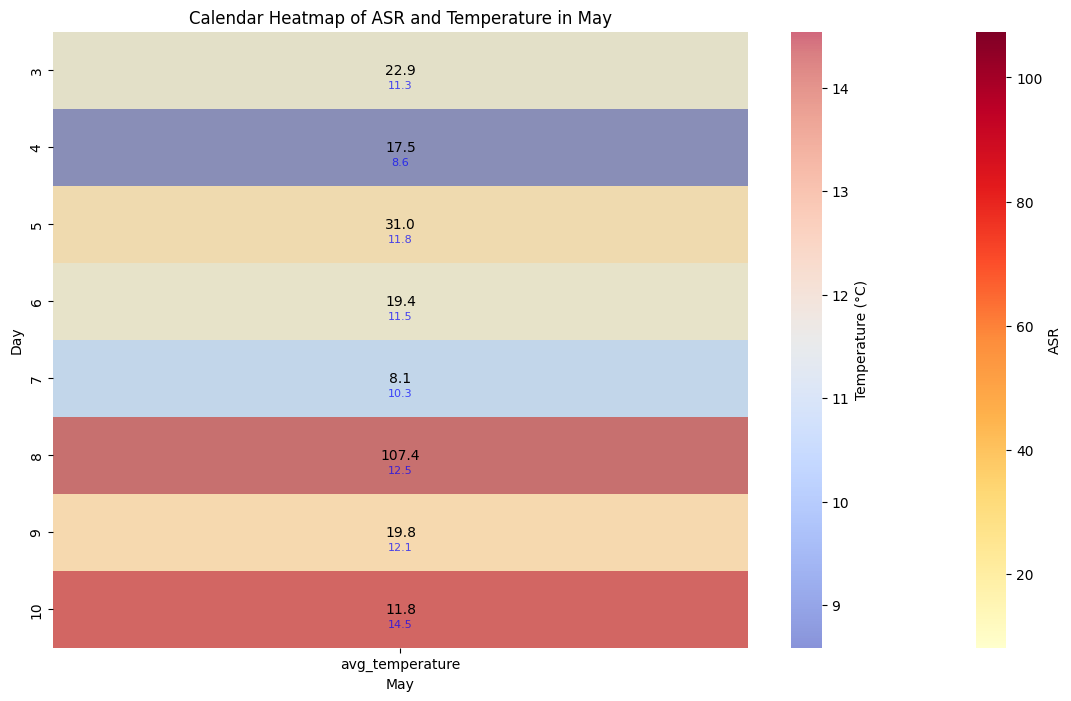

In [27]:
# 创建一个新的 DataFrame 用于热图
heatmap_df = merged_df[['date', 'avg_temperature', 'ASR']].copy()  # 使用 .copy() 创建副本
heatmap_df['day'] = heatmap_df['date'].apply(lambda x: x.day)

# 创建透视表
pivot_table_asr = heatmap_df.pivot_table(index='day', values='ASR', aggfunc='mean')
pivot_table_temp = heatmap_df.pivot_table(index='day', values='avg_temperature', aggfunc='mean')

# 绘制热图
fig, ax = plt.subplots(figsize=(14, 8))

# 绘制 ASR 热图
sns.heatmap(pivot_table_asr, cmap="YlOrRd", annot=False, cbar_kws={'label': 'ASR'}, ax=ax)

# 在同一张图中绘制温度热图
sns.heatmap(pivot_table_temp, cmap="coolwarm", annot=False, cbar_kws={'label': 'Temperature (°C)'}, alpha=0.6, ax=ax)

# 添加 ASR 和温度的注释
for i in range(len(pivot_table_asr)):
    for j in range(len(pivot_table_asr.columns)):
        asr_value = pivot_table_asr.iloc[i, j]
        temp_value = pivot_table_temp.iloc[i, j]
        ax.text(j + 0.5, i + 0.5, f"{asr_value:.1f}", color='black', ha='center', va='center', fontsize=10)
        ax.text(j + 0.5, i + 0.7, f"{temp_value:.1f}", color='blue', ha='center', va='center', fontsize=8, alpha=0.7)

# 设置轴标签和标题
ax.set_title('Calendar Heatmap of ASR and Temperature in May')
ax.set_xlabel('May')
ax.set_ylabel('Day')

plt.show()